<a href="https://www.kaggle.com/code/averma111/pytorch-cafa-5-prediction?scriptVersionId=130498850" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture 
!pip install torchmetrics

In [2]:
%%capture
!pip install torchsummary

In [3]:
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
import torch
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import AUROC
from torchsummary import summary as torchsummary


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
def get_dataframe(path):
    return pd.read_csv(path,sep='\t')

In [5]:
train_terms = '/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv'
train_taxonomy ='/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv'

In [6]:
get_dataframe(train_terms).head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [13]:
get_dataframe(train_taxonomy).head()


,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In [7]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_terms)))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%
train_terms shape: (5363863, 3)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
term,category,0,31466,NaN,NaN,NaN,NaN,NaN,0
aspect,category,0,3,NaN,NaN,NaN,NaN,NaN,0


In [10]:
summary('train_terms',reduce_mem_usage(get_dataframe(train_taxonomy)))

Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 6.20 MB
Decreased by -185.7%
train_terms shape: (142246, 2)


,dtypes,null,unique,min,median,max,mean,std,duplicate
EntryID,category,0,142246,NaN,NaN,NaN,NaN,NaN,0
taxonomyID,int32,0,3156,24.0,9606.0,2902295.0,76300.078814,173917.278619,0


Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


<AxesSubplot: xlabel='aspect', ylabel='count'>

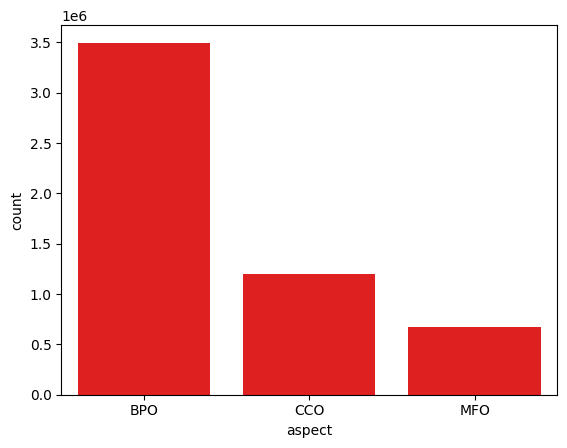

In [11]:
sns.countplot(data=reduce_mem_usage(get_dataframe(train_terms)),x='aspect',color='r')

In [13]:
train_terms=reduce_mem_usage(get_dataframe(train_terms))

Memory usage of dataframe is 122.77 MB
Memory usage after optimization is: 42.17 MB
Decreased by 65.6%


In [63]:
terms=train_terms.groupby(['aspect', 'term'])['term'].count().reset_index(name='frequency')
fractions = (terms.groupby('aspect')['term'].nunique() / terms['term'].nunique() * 500).apply(round)
print(fractions)

In [69]:
selected_terms = set()
for aspect, number in fractions.items():
    selection = terms.loc[(terms.aspect == aspect)]
    selection = selection.nlargest(number, columns='frequency', keep='first')
    selected_terms.update(selection.term.to_list())

In [ ]:
%%time 
def assign_labels(annotations, selected_terms=selected_terms):
    intersection = selected_terms.intersection(annotations)
    labels = np.isin(np.array(list(selected_terms)), np.array(list(intersection)))
    return list(labels.astype('int'))

annotations = train_terms.groupby('EntryID')['term'].apply(set)
labels = annotations.progress_apply(assign_labels)

labels.head()

  0%|          | 0/142246 [00:00<?, ?it/s]

In [24]:
def get_features_labels():
    train_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
    X = np.load('/kaggle/input/t5embeds/train_embeds.npy')
    y = np.array(labels[train_ids].to_list())
    return X,y

In [25]:
def train_test_dataset(features,labels):
    return  train_test_split(features,labels,test_size=0.2,shuffle=True,random_state=42)

X_train,X_val,y_train,y_val = train_test_dataset(*get_features_labels())
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(113796, 1024) (28450, 1024) (113796, 3) (28450, 3)


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
def convert_to_torch(value):
    return torch.tensor(data=value,dtype=torch.float32,requires_grad=True,device=device)

In [28]:
class CAFA5Data(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = convert_to_torch(X_train)
y_data = convert_to_torch(y_train)
X_val = convert_to_torch(X_val)
y_val = convert_to_torch(y_val)
train_data = CAFA5Data(X_data,y_data)
test_data = CAFA5Data(X_val,y_val)

In [48]:
class CAFA5NNetBase(torch.nn.Module):
    
    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self, batch):
        features, labels = batch 
        out = self(features)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = auroc(out, labels)           # Calculate accuracy
        return {'Validation_loss': loss.detach(), 'Validation_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Validation_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Validation_loss': epoch_loss.item(), 'Valdation_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], Train_loss: {:.4f}, Validation_loss: {:.4f}, Validation_acc: {:.4f}".format(
            epoch, result['Train_loss'], result['Validation_loss'], result['Validation_acc']))

In [49]:
class CAFA5NNet(CAFA5NNetBase):
    def __init__(self,input_features,output_features):
        super(CAFA5NNet,self).__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(input_features,1012),
        torch.nn.ReLU(),
        torch.nn.Linear(1012,712),    
        torch.nn.ReLU(),
        torch.nn.Linear(712,output_features)
        )
    def forward(self,inputs):
        return self.network(inputs)

In [50]:
model = CAFA5NNet(X_train.shape[1],y_train.shape[1])
model.to(device)

CAFA5NNet(
  (network): Sequential(
    (0): Linear(in_features=1024, out_features=1012, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1012, out_features=712, bias=True)
    (3): ReLU()
    (4): Linear(in_features=712, out_features=3, bias=True)
  )
)

In [51]:
torchsummary(model, X_data.size(), batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [-1, 113796, 1012]       1,037,300
              ReLU-2         [-1, 113796, 1012]               0
            Linear-3          [-1, 113796, 712]         721,256
              ReLU-4          [-1, 113796, 712]               0
            Linear-5            [-1, 113796, 3]           2,139
Total params: 1,760,695
Trainable params: 1,760,695
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 444.52
Forward/backward pass size (MB): 2996.14
Params size (MB): 6.72
Estimated Total Size (MB): 3447.37
----------------------------------------------------------------


In [52]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.1
MOMENTUM = 0.9
OPT_FUNC = torch.optim.Adam

In [53]:
def get_dataloaders(dataset_type,batch,shuffle):
    if shuffle:
         return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
    else:
        return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)
    
train_dl = get_dataloaders(train_data,BATCH_SIZE,True)
val_dl = get_dataloaders(test_data,BATCH_SIZE,False)

In [54]:
def auroc(outputs, labels):
    auroc = AUROC(task="multiclass", num_classes=2)
    return auroc(outputs, labels)

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = OPT_FUNC):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['Train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [55]:
history = fit(EPOCHS, LEARNING_RATE, model, train_dl, val_dl,OPT_FUNC)

  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Expected `preds` to have one more dimension than `target` but got 2 and 2

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history]
    val_losses = [x['Validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
test_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
x_test = np.load('/kaggle/input/t5embeds/test_embeds.npy')

In [ ]:
predictions = model.predict(x_test)
del x_test
gc.collect()

chunk_size = 5_000
chunks = [range(i, min(i + chunk_size, len(predictions))) for i in range(0, len(predictions), chunk_size)]

final_sub = pd.DataFrame()  # Create an empty DataFrame to hold the final result

print(f"processing {len(chunks)} chunks of {chunk_size} predictions each")

for chunk in chunks:
    print(f"processing chunk {chunk}")
    sub = pd.DataFrame(data=predictions[chunk], columns=list(selected_terms), index=test_ids[chunk])
    sub = sub.T.unstack().reset_index(name='prediction')
    sub = sub.loc[sub['prediction'] > 0]
    final_sub = pd.concat([final_sub, sub])  # Concatenate current chunk DataFrame to the final DataFrame

final_sub.head()